Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### Preliminary snippets

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);

Center weight and store as weight_c

In [5]:
mean_weight = mean(df2[:weight])
df2 = hcat(df2, df2[:weight] .- mean_weight)
rename!(df2, :x1 => :weight_c); # Rename our col :x1 => :weight_c
first(df2, 5)

5×5 DataFrame
│ Row │ height  │ weight  │ age     │ male  │ weight_c │
│     │ Float64 │ Float64 │ Float64 │ Int64 │ Float64  │
├─────┼─────────┼─────────┼─────────┼───────┼──────────┤
│ 1   │ 151.765 │ 47.8256 │ 63.0    │ 1     │ 2.83512  │
│ 2   │ 139.7   │ 36.4858 │ 63.0    │ 0     │ -8.50468 │
│ 3   │ 136.525 │ 31.8648 │ 65.0    │ 0     │ -13.1256 │
│ 4   │ 156.845 │ 53.0419 │ 41.0    │ 1     │ 8.05143  │
│ 5   │ 145.415 │ 41.2769 │ 51.0    │ 0     │ -3.71361 │

Define the Stan language model

In [6]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [7]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchains);
# Input data for cmdstan.
heightsdata = Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight_c]);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.stan will be updated.



Sample using cmdstan

In [8]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# ### Snippet 4.47
# Show first 5 draws of correlated parameter values in chain 1
chn.value[1:5,:,1]

5×3 AxisArrays.AxisArray{Float64,2,Array{Float64,2},Tuple{AxisArrays.Axis{:iter,StepRange{Int64,Int64}},AxisArrays.Axis{:var,Array{String,1}}}}:
 154.869  0.859041  4.89064
 154.874  0.87734   5.39454
 154.364  0.857704  5.12304
 154.845  0.837613  4.95354
 154.641  0.87237   4.92528

### Snippets 4.48 & 4.49

Plot estimates using the N = [10, 50, 150, 352] observations

In [9]:
nvals = [10, 50, 150, 352];

Create the 4 nvals plots

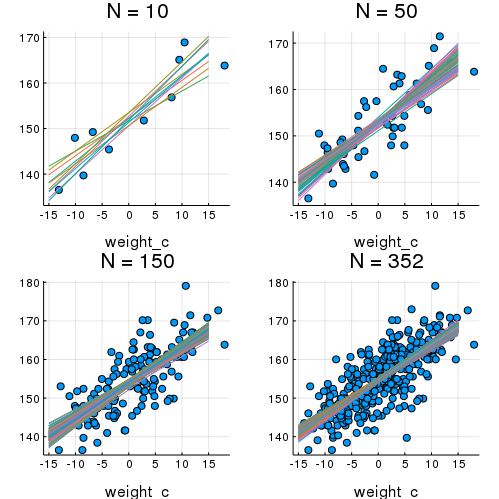

In [10]:
p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
for i in 1:length(nvals)
  N = nvals[i]
  heightsdataN = [
    Dict("N" => N, "height" => df2[1:N, :height], "weight" => df2[1:N, :weight_c])
  ]
  rc, chnN, cnames = stan(stanmodel, heightsdataN, ProjDir, diagnostics=false,
    summary=false, CmdStanDir=CMDSTAN_HOME)

  rws, vars, chns = size(chnN)
  xi = -15.0:0.1:15.0
  alpha_vals = convert(Vector{Float64}, reshape(chnN.value[:, 1, :], (rws*chns)))
  beta_vals = convert(Vector{Float64}, reshape(chnN.value[:, 2, :], (rws*chns)))

  p[i] = scatter(df2[1:N, :weight_c], df2[1:N, :height], leg=false, xlab="weight_c")
  for j in 1:N
    yi = alpha_vals[j] .+ beta_vals[j]*xi
    plot!(p[i], xi, yi, title="N = $N")
  end
end
plot(p..., layout=(2, 2))

### Snippet 4.50

Get dimensions of chains

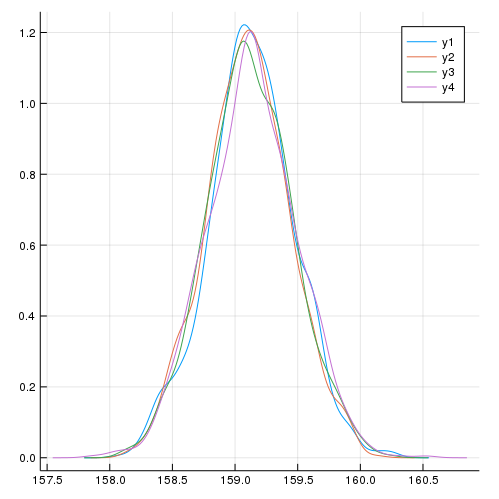

In [11]:
rws, vars, chns = size(chn)
mu_at_50 = link(50:10:50, chn, [1, 2], mean_weight);
density(mu_at_50)

### Snippet 4.54

Show posterior density for 6 mu_bar values

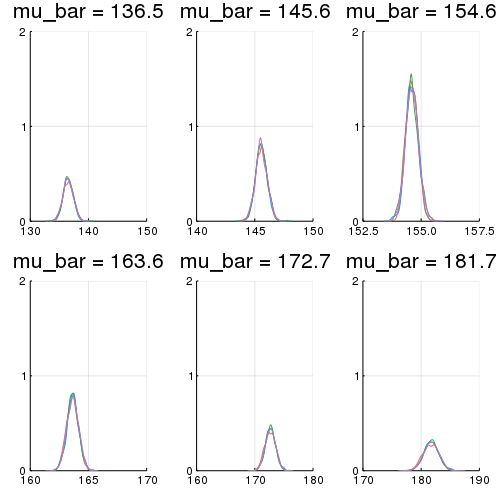

In [12]:
mu = link(25:10:75, chn, [1, 2], mean_weight);

q = Vector{Plots.Plot{Plots.GRBackend}}(undef, size(mu, 1))
for i in 1:size(mu, 1)
  q[i] = density(mu[i], ylim=(0.0, 1.5),
    leg=false, title="mu_bar = $(round(mean(mu[i]), digits=1))")
end
plot(q..., layout=(2, 3), ticks=(3))

End of `clip_48_54s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*